In [2]:
import glob
import os
import math

from time import time

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K

from keras import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input
from keras.models import load_model
from keras.optimizers import Adam
from skimage import color
from multiprocessing import Pool
from keras.layers import Conv2D, Dense, GlobalAveragePooling2D, LSTM, TimeDistributed, UpSampling2D
from keras.engine import Layer
from keras.utils import plot_model

from collections import namedtuple
from datetime import datetime
from os import listdir
from os.path import join, isfile

import re
import cv2
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [3]:
!ls drive/My\ Drive/checkpoints

ls: cannot access 'drive/My Drive/checkpoints': No such file or directory


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -xzf drive/My\ Drive/elephant.tar.gz -C drive/My\ Drive/

In [0]:
!mv drive/My\ Drive/elephant_output/* drive/My\ Drive/original
# !mv drive/My\ Drive/amazon_output/* drive/My\ Drive/original

In [0]:
tf.flags.DEFINE_integer("train_shards", 48,
                        "Number of shards in training TFRecord files.")
tf.flags.DEFINE_integer("val_shards", 8,
                        "Number of shards in validation TFRecord files.")
tf.flags.DEFINE_integer("test_shards", 8,
                        "Number of shards in testing TFRecord files.")
tf.flags.DEFINE_integer("num_threads", 8,
                        "Number of threads to pre-process the videos.")
FLAGS = tf.flags.FLAGS

VideoMetaData = namedtuple("VideoMetaData", ["video_id", "lab_file", "resnet_file"])


def _int64_feature(value):
    """Wrapper for inserting an int64 Feature into a SequenceExample proto."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    """Wrapper for inserting a bytes Feature into a SequenceExample proto."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tobytes()]))


def _int64_feature_list(values):
    """Wrapper for inserting an int64 FeatureList into a SequenceExample proto."""
    return tf.train.FeatureList(feature=[_int64_feature(v) for v in values])


def _bytes_feature_list(values):
    """Wrapper for inserting a bytes FeatureList into a SequenceExample proto."""
    return tf.train.FeatureList(feature=[_bytes_feature(v) for v in values])


class TFRecordBuilder:
    def __init__(self, resnet_folder, lab_folder):
        self.resnet_folder = resnet_folder
        self.lab_folder = lab_folder

    @staticmethod
    def _to_sequence_example(video):
        """Builds a SequenceExample proto for video lab file and embeddings.

        Args:
          video: An VideoMetadata object.

        Returns:
          A SequenceExample proto.
        """
        video_id = video.video_id
        resnet_file = video.resnet_file
        lab_file = video.lab_file
        resnet_record = np.load(resnet_file)
        lab_images = np.load(lab_file)
        L = lab_images[:, :, :, 0]
        A = lab_images[:, :, :, 1]
        B = lab_images[:, :, :, 2]
        embeddings = resnet_record

        # try:
        #     decoder.decode_jpeg(encoded_image)
        # except (tf.errors.InvalidArgumentError, AssertionError):
        #     print("Skipping file with invalid JPEG data: %s" % video.filename)
        #     return

        context = tf.train.Features(feature={
            "video/video_id": _int64_feature(video_id),
        })

        feature_lists = tf.train.FeatureLists(feature_list={
            "video/l_layer": _bytes_feature_list(L),
            "video/a_layer": _bytes_feature_list(A),
            "video/b_layer": _bytes_feature_list(B),
            "video/resnet_embedding": _bytes_feature_list(embeddings),
            "video/frame_ids": _int64_feature_list([x for x in range(frames_per_video)])
        })
        sequence_example = tf.train.SequenceExample(
            context=context, feature_lists=feature_lists)

        return sequence_example

    @staticmethod
    def _process_video_data_files(thread_index, ranges, name, video_metadata, num_shards):
        """Processes and saves a subset of restnet embeddings and lab files as TFRecord files in one thread.

        Args:
          thread_index: Integer thread identifier within [0, len(ranges)].
          ranges: A list of pairs of integers specifying the ranges of the dataset to
            process in parallel.
          name: Unique identifier specifying the dataset.
          video_metadata: List of VideoMetadata.
          num_shards: Integer number of shards for the output files.
        """
        # Each thread produces N shards where N = num_shards / num_threads. For
        # instance, if num_shards = 128, and num_threads = 2, then the first thread
        # would produce shards [0, 64).
        num_threads = len(ranges)
        assert not num_shards % num_threads
        num_shards_per_batch = int(num_shards / num_threads)

        shard_ranges = np.linspace(ranges[thread_index][0], ranges[thread_index][1],
                                   num_shards_per_batch + 1).astype(int)
        num_videos_in_thread = ranges[thread_index][1] - ranges[thread_index][0]

        counter = 0
        for s in range(num_shards_per_batch):
            # Generate a sharded version of the file name, e.g. 'train-00002-of-00010'
            shard = thread_index * num_shards_per_batch + s
            output_filename = "%s-%.5d-of-%.5d" % (name, shard, num_shards)
            output_file = os.path.join(dir_tfrecord, output_filename)
            writer = tf.python_io.TFRecordWriter(output_file)

            shard_counter = 0
            videos_in_shard = np.arange(shard_ranges[s], shard_ranges[s + 1], dtype=int)
            for i in videos_in_shard:
                video = video_metadata[i]

                sequence_example = TFRecordBuilder._to_sequence_example(video)
                if sequence_example is not None:
                    writer.write(sequence_example.SerializeToString())
                    shard_counter += 1
                    counter += 1

                if not counter % 1000:
                    print("%s [thread %d]: Processed %d of %d items in thread batch." %
                          (datetime.now(), thread_index, counter, num_videos_in_thread))
                    sys.stdout.flush()

            writer.close()
            print("%s [thread %d]: Wrote %d video data to %s" %
                  (datetime.now(), thread_index, shard_counter, output_file))
            sys.stdout.flush()
            shard_counter = 0
        print("%s [thread %d]: Wrote %d video data to %d shards." %
              (datetime.now(), thread_index, counter, num_shards_per_batch))
        sys.stdout.flush()

    @staticmethod
    def process_dataset(name, video_metadata, num_shards):
        """Processes a complete data set and saves it as a TFRecord.

        Args:
          name: Unique identifier specifying the dataset.
          video_metadata: List of VideoMetadata.
          num_shards: Integer number of shards for the output files.
        """
        # video_metadata = [VideoMetadata(video_id, lab_file, restnet_file)

        # Shuffle the ordering of videos. Make the randomization repeatable.
        random.seed(12345)
        random.shuffle(video_metadata)

        # Break the video_metadata into num_threads batches. Batch i is defined as
        # video_metadata[ranges[i][0]:ranges[i][1]].
        num_threads = min(num_shards, FLAGS.num_threads)
        spacing = np.linspace(0, len(video_metadata), num_threads + 1).astype(np.int)
        ranges = []
        threads = []
        for i in range(len(spacing) - 1):
            ranges.append([spacing[i], spacing[i + 1]])

        # Create a mechanism for monitoring when all threads are finished.
        coord = tf.train.Coordinator()

        # Create a utility for decoding videos to run sanity checks.
        # decoder = VideoDecoder()

        # Launch a thread for each batch.
        print("Launching %d threads for spacings: %s" % (num_threads, ranges))
        for thread_index in range(len(ranges)):
            args = (thread_index, ranges, name, video_metadata, num_shards)
            t = threading.Thread(target=TFRecordBuilder._process_video_data_files, args=args)
            t.start()
            threads.append(t)

        # Wait for all the threads to terminate.
        coord.join(threads)
        print("%s: Finished processing all %d video resnet and lab pairs in data set '%s'." %
              (datetime.now(), len(video_metadata), name))

    @staticmethod
    def load_and_process_metadata(resnet_records_dir, lab_records_dir):
        """Loads video metadata from .npy files

        Args:

        Returns:
          A list of available LAB color files and restnet embedding files.
        """
        resnet_records = []
        for file_name in os.listdir(resnet_records_dir):
            resnet_records.append(join(resnet_records_dir, file_name))
        resnet_records = sorted(resnet_records)

        lab_records = []
        for file_name in os.listdir(lab_records_dir):
            lab_records.append(join(lab_records_dir, file_name))
        lab_records = sorted(lab_records)

        video_metadata = []
        for id in range(len(lab_records)):
            video_metadata.append(VideoMetaData(id, lab_records[id], resnet_records[id]))

        return video_metadata

    def process(self, train_size, val_size, test_size):
        metadata = tfRecordBuilder.load_and_process_metadata(self.resnet_folder, self.lab_folder)
        random.shuffle(metadata)

        train_cutoff = train_size
        val_cutoff = train_cutoff + val_size

        train_dataset = metadata[: train_cutoff]
        val_dataset = metadata[train_cutoff: val_cutoff]
        test_dataset = metadata[val_cutoff:]

        tfRecordBuilder.process_dataset("train", train_dataset, FLAGS.train_shards)
        tfRecordBuilder.process_dataset("val", val_dataset, FLAGS.val_shards)
        tfRecordBuilder.process_dataset("test", test_dataset, FLAGS.test_shards)

In [0]:
class Sample:
    def __init__(self, source_dir, dest_dir, length=3, skip=1):
        self.source_dir = source_dir
        self.dest_dir = dest_dir
        self.length = length
        self.skip = skip

    def save_sliced_video(self, input_file, output_file):
        try:
            video = cv2.VideoCapture(input_file)
            count = 0
            frames = []
            frames_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            start_frame = int(frames_count/2)
            video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            while count < self.length:
                ret, frame = video.read()
                if not ret:
                    break
                if int(video.get(cv2.CAP_PROP_POS_FRAMES)) % self.skip != 0:
                    continue
                frames.append(frame)
                count += 1
            flag = len(frames) == self.length
            fps = video.get(cv2.CAP_PROP_FPS)
            size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            out = cv2.VideoWriter(output_file, fourcc, fps, size)
            # check if video has required length if not return false
            # assert len(frames) == frames_per_video
            if flag:
                for f in frames:
                    out.write(f)
            video.release()
            out.release()
            return flag
        except:
            return False

    def slice_all(self):
        # iterate over each file in the source directory
        file_list = listdir(self.source_dir)
        print("Start sampling %d files" % len(file_list))
        count = 0
        for file_name in file_list:
            input_file = join(self.source_dir, file_name)
            new_file_name = "video_" + format(count, '05d') + ".avi"
            output_file = join(self.dest_dir, new_file_name)
            if isfile(input_file):
                flag = self.save_sliced_video(input_file, output_file)
                if flag:
                    count += 1
            if count % 10 == 0:
                print("Processed %d out of %d" % (count, len(file_list)))
        print("Sampling completed %d out of %d" % (count, len(file_list)))

In [0]:
def get_video(file):
    '''
    Parameters
    ----------
    file - path to video file

    Returns
    -------
    frames - frames array of the video
    '''

    video = cv2.VideoCapture(file)
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    frames = np.asarray(frames)
    return frames


def get_lab_layer(frames):
    '''
        Parameters
        -----------
        frames - color/gray video frames with 3 chanels

        Returns
        -------
        (rgb2lab, gray2lab) - RGB frames converted to LAB, GRAY frames converted to LAB
    '''
    rgb2lab_frames = []
    gray2lab_frames = []

    for frame in frames:
        resized_frame = resize_pad_frame(frame, (default_nn_input_height, default_nn_input_width), equal_padding=True)

        rgb2lab_frame = color.rgb2lab(resized_frame)
        rgb2lab_frames.append(rgb2lab_frame)

        rgb2gray_frame = color.rgb2gray(resized_frame)

        # Display Grayscale frame
        cv2.imshow('grey', rgb2gray_frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        gray2rgb_frame = color.gray2rgb(rgb2gray_frame)
        lab_frame = color.rgb2lab(gray2rgb_frame)
        gray2lab_frames.append(lab_frame)

    return np.asarray(rgb2lab_frames), np.asarray(gray2lab_frames)


def preprocess_frames(gray2lab_frames):
    '''
    Parameters
    ---------
    gray2lab_frames - LAB frames of Grayscale video

    Returns
    -------
    processed_l_layer - L Layer processed (L/50 - 1)
    '''
    print(gray2lab_frames)
    print(gray2lab_frames.shape)
    processed = np.empty(gray2lab_frames.shape)

    processed[:, :, :, 0] = np.divide(gray2lab_frames[:, :, :, 0], 50) - 1  # data loss
    processed[:, :, :, 1] = np.divide(gray2lab_frames[:, :, :, 1], 128)
    processed[:, :, :, 2] = np.divide(gray2lab_frames[:, :, :, 2], 128)

    processed_l_layer = processed[:, :, :, np.newaxis, 0]

    return processed_l_layer


def get_resnet_records(frames):
    '''
    Parameters
    ----------
    frames - original frames without color conversion or resizing

    Details
    -------
    Implementation adopted from Deep Kolorization implementation

    Returns
    -------
    predictions - restnet predictions
    '''
    resnet_input = []
    for frame in frames:
        resized_frame = resize_pad_frame(frame, (resnet_input_height, resnet_input_width))
        gray_scale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)
        gray_scale_frame_colored = cv2.cvtColor(gray_scale_frame, cv2.COLOR_GRAY2RGB)
        resnet_input.append(gray_scale_frame_colored)
    resnet_input = np.asarray(resnet_input)

    predictions = inception_resnet_v2_predict(resnet_input)
    return predictions


def getInputRange(frames_count, time_steps, current_frame):
    '''
    Deciding the moving window
    '''
    # this function should change according to our selection of
    frame_selection = []
    last_selection = current_frame
    for i in range(current_frame, current_frame - time_steps, -1):
        if (i < 0):
            frame_selection.append(last_selection)
        else:
            frame_selection.append(i)
            last_selection = i
    frame_selection = frame_selection[::-1]
    return frame_selection


def get_nn_input(l_layer, resnet_out):
    '''
    Define the flowchroma input
    '''
    frames_count = l_layer.shape[0]
    time_steps = frames_per_video
    X = []
    Y = []

    for i in range(frames_count):
        frame_index_selection = getInputRange(frames_count, time_steps, i)
        frame_selection = []
        resnet_selection = []
        for j in frame_index_selection:
            frame_selection.append(l_layer[j])
            resnet_selection.append(resnet_out[j])
        X.append(frame_selection)
        Y.append(resnet_selection)

    X = np.asarray(X)
    Y = np.asarray(Y)
    return [X, Y]


def post_process_predictions(original_l_layers, predicted_AB_layers):
    '''
    Combine original L layer and predicted AB Layers
    '''
    time_steps = frames_per_video
    total_frames = original_l_layers.shape[0]
    predicted_frames = []
    for i in range(total_frames):
        l_layer = original_l_layers[i]
        a_layer = np.multiply(predicted_AB_layers[i, time_steps - 1, :, :, 0],
                              128)  # select the first frame outof three predictions
        b_layer = np.multiply(predicted_AB_layers[i, time_steps - 1, :, :, 1], 128)
        frame = np.empty((240, 320, 3))
        frame[:, :, 0] = l_layer
        frame[:, :, 1] = a_layer
        frame[:, :, 2] = b_layer
        # frame = color.lab2rgb(frame)
        predicted_frames.append(frame)
    return np.asarray(predicted_frames)


def save_output_video(frames, output_file):
    '''
    Save the output video
    '''
    fps = 20
    size = (320, 240)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file, fourcc, fps, size)
    for frame in frames:
        final_out = color.lab2rgb(frame)
        final_out_write_video = final_out * 255  
        # color.lab2rgb results values in [0,1]
        final_out_write_video = final_out_write_video.astype(np.uint8)
        out.write(final_out_write_video)
    out.release()


def process_test_file(file):
    # Pre-processing
    frames = get_video(dir_test+'/'+file)
    (rgb2lab_frames, gray2lab_frames) = get_lab_layer(frames)
    processed_l_layer = preprocess_frames(gray2lab_frames)
    print('running resnet model')
    predictions = get_resnet_records(frames)
    print('Combining L layer and resnet out')
    X = get_nn_input(processed_l_layer, predictions)

    # Predicting
    ckpts = glob.glob("/content/drive/My Drive/checkpoints/*.hdf5")
    latest_ckpt = max(ckpts, key=os.path.getctime)
    print("loading from checkpoint:", latest_ckpt)
    model = load_model(latest_ckpt, custom_objects={'FusionLayer': FusionLayer})
    predictions = []
    for i in range(X[0].shape[0]):
        predictions.append(model.predict([X[0][i:i + 1], X[1][i:i + 1]])[0])  # shape is (1, 3, 240, 320, 2)
    predictions = np.asarray(predictions)
    print("Model predictions calculated")

    # Post processing
    frame_predictions = post_process_predictions(gray2lab_frames[:, :, :, 0], predictions)

    save_output_video(frame_predictions, dir_test_results+ '/' + file.split('.')[0] + '.avi')

In [0]:
class DataGenerator(keras.utils.Sequence):
    """
    Generates data for the Keras model
    """

    def __init__(self,
                 resnet_path,
                 lab_path,
                 file_ids,
                 batch_size=2,
                 time_steps=3,
                 h=240,
                 w=320,
                 shuffle=True):

        self.resnet_path = resnet_path
        self.lab_path = lab_path
        self.file_ids = file_ids

        self.batch_size = batch_size
        self.time_steps = time_steps
        self.h = h
        self.w = w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.file_ids) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        batch_file_ids = [self.file_ids[k] for k in indexes]

        # Generate data
        return self.__data_generation(batch_file_ids)

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.file_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_file_ids):
        """
        Generates data containing batch_size samples
        """

        x = [np.empty((self.batch_size, self.time_steps, self.h, self.w, 1)),
             np.empty((self.batch_size, self.time_steps, 1000))]

        y = np.empty((self.batch_size, self.time_steps, self.h, self.w, 2))

        # Generate data
        for i, file_id in enumerate(batch_file_ids):
            lab_record = np.load('{0}/lab_record_{1}.npy'.format(self.lab_path, file_id))
            resnet_record = np.load('{0}/resnet_record_{1}.npy'.format(self.resnet_path, file_id))

            x[0][i, :, :, :, 0] = lab_record[:, :, :, 0]
            x[1][i, :, :] = resnet_record

            y[i, :, :, :, :] = lab_record[:, :, :, 1:]

        return x, y


In [0]:
class ImageRecord:
    def __init__(self, input_dir, output_dir, size, equal_padding):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.size = size
        self.equal_padding = equal_padding

    @staticmethod
    def write_to_csv(file, output_file, size, equal_padding):
        """
        Read content from AVI file and resize frames and convert frames to LAB color space
        :param file: video file
        :param output_file: LAB output file
        :param size: (width, height)
        :param equal_padding: True/False
        """
        video = cv2.VideoCapture(file)
        frames = []
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                break
            frame = resize_pad_frame(frame, size, equal_padding=equal_padding)
            # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)
            frame = color.rgb2lab(frame)
            frames.append(frame)
        frames = np.asarray(frames)

        # LAB layers should be brought to [-1, +1] region
        frames[:, :, :, 0] = np.divide(frames[:, :, :, 0], 50) - 1
        frames[:, :, :, 1] = np.divide(frames[:, :, :, 1], 128)
        frames[:, :, :, 2] = np.divide(frames[:, :, :, 2], 128)

        np.save(output_file, frames)

    def write_all(self):
        file_list = []
        for file_name in listdir(self.input_dir):
            file_list.append(join(self.input_dir, file_name))
        file_list = sorted(file_list)

        print("Start processing %d files" % len(file_list))
        for i in range(len(file_list)):
            self.write_to_csv(file_list[i], join(self.output_dir, "lab_record_" + format(i, '05d')), self.size,
                              self.equal_padding)
            if i % 10 == 0:
                print("Processed %d out of %d" % (i, len(file_list)))
        print("LAB conversion completed")

In [0]:
class ResnetRecordCreator:
    def __init__(self, video_dir, image_dir, record_dir):
        self.video_dir = video_dir
        self.image_dir = image_dir
        self.record_dir = record_dir

    def convert_all(self, file_list):
        """
        Convert videos in the source directory to images
        :return:
        """
        video_frames = []
        video_indexes = []
        for file_name in file_list:
            input_file = join(self.video_dir, file_name)

            # self.convert_video_to_images(input_file, sample_count)
            sample_index = int(re.search("video_(.*).avi", file_name).group(1))
            resized_frames = self.convert_video_to_images(input_file)

            assert len(resized_frames) == frames_per_video

            video_indexes.append(sample_index)
            video_frames += resized_frames
            print("Video %d converted to frames" % sample_index)
        return [video_indexes, np.asarray(video_frames)]

    def convert_video_to_images(self, input_file):
        """
        convert a single video file to images
        :param input_file:
        :param sample_count:
        :return:
        """
        video = cv2.VideoCapture(input_file)
        frames = []
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                break
            frame = resize_pad_frame(frame, (resnet_input_height, resnet_input_width))
            gray_scale_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            gray_scale_frame_colored = cv2.cvtColor(gray_scale_frame, cv2.COLOR_GRAY2RGB)
            frames.append(gray_scale_frame_colored)
        return frames

    def predict_all(self, video_details):
        video_indexes, video_frames = video_details
        predictions = inception_resnet_v2_predict(video_frames)
        self.write_files(video_indexes, predictions)

    def write_files(self, video_indexes, predictions):
        for i in range(len(video_indexes)):
            frames_start = i * frames_per_video
            frames_end = frames_start + frames_per_video
            file_index = video_indexes[i]
            file_content = predictions[frames_start:frames_end]
            output_file = join(self.record_dir, "resnet_record_" + format(file_index, "05d"))
            np.save(output_file, file_content)

    def process_all(self):
        file_list = listdir(self.video_dir)
        file_list = sorted(file_list)

        for chunk in self.chunks(file_list, resnet_video_chunk_size):
            # convert to images of the size 299x299
            video_details = self.convert_all(chunk)
            # pass those images to RestNet
            self.predict_all(video_details)

            print("Chunk completed")

    @staticmethod
    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in range(0, len(l), n):
            yield l[i:i + n]

In [0]:
def process_file(index):
    lab_record = np.load(join(dir_lab_records, "lab_record_" + format(index, '05d') + ".npy"))
    resnet_record = np.load(join(dir_resnet_csv, "resnet_record_" + format(index, "05d") + ".npy"))
    for i in range(frames_per_video):
        np.save(join(dir_frame_lab_records, "lab_record_" + format(index * frames_per_video + i, '08d')), lab_record[i])
        np.save(join(dir_frame_resnet_records,"resnet_record_" + format(index * frames_per_video + i, '08d')), resnet_record[i])
    print('Index ' + str(index) + ' done')

def prepare_image_data():
    lab_records = listdir(dir_lab_records)
    resnet_records = listdir(dir_resnet_csv)

    assert len(lab_records) == len(resnet_records)
    n = len(lab_records)

    file_indexes = [x for x in range(n)]
    pool = Pool(2)
    pool.map(process_file, file_indexes)

In [0]:
def resize_pad_frame(img, size, pad_color=255, equal_padding=True):
    """
    Resize the frame,
    If image is a horizontal one first match the horizontal axis then resize vertical axis and fill the remaining
    with padding color, similar process for vertical images
    :param equal_padding:
    :param img: frame to be resized
    :param size: final frame size
    :param pad_color: color of tha padding
    :return: re-sized frame
    """
    h, w = float(img.shape[0]), float(img.shape[1])
    expected_height, expected_width = size

    # interpolation method
    if h > expected_height or w > expected_width:  # shrinking image
        interp = cv2.INTER_AREA
    else:  # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w / h

    # compute scaling and pad sizing
    if aspect >= 1:  # horizontal image
        new_w = expected_width
        new_h = np.round(new_w / aspect).astype(int)
        if expected_height >= new_h:
            if equal_padding:
                pad_vert = (expected_height - new_h) / 2.0
                pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
                pad_left, pad_right = 0, 0
            else:
                pad_vert = (expected_height - new_h)
                pad_top, pad_bot = 0, pad_vert
                pad_left, pad_right = 0, 0
        else:
            new_h = expected_height
            new_w = np.round(new_h * aspect).astype(int)
            if equal_padding:
                pad_horz = (expected_width - new_w) / 2
                pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
                pad_top, pad_bot = 0, 0
            else:
                pad_horz = (expected_width - new_w)
                pad_left, pad_right = 0, pad_horz
                pad_top, pad_bot = 0, 0

    elif aspect < 1:  # vertical image
        new_h = expected_height
        new_w = np.round(new_h * aspect).astype(int)
        if expected_width >= new_w:
            if equal_padding:
                pad_horz = (expected_width - new_w) / 2
                pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
                pad_top, pad_bot = 0, 0
            else:
                pad_horz = (expected_width - new_w)
                pad_left, pad_right = 0, pad_horz
                pad_top, pad_bot = 0, 0
        else:
            new_w = expected_width
            new_h = np.round(new_w / aspect).astype(int)
            if equal_padding:
                pad_vert = (expected_height - new_h) / 2.0
                pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
                pad_left, pad_right = 0, 0
            else:
                pad_vert = (expected_height - new_h)
                pad_top, pad_bot = 0, pad_vert
                pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(pad_color,
                                              (list, tuple, np.ndarray)):  # color image but only one color provided
        pad_color = [pad_color] * 3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right,
                                    borderType=cv2.BORDER_CONSTANT, value=pad_color)

    return scaled_img


In [0]:
class FrameExtractor:
    def __init__(self, input_dir, output_dir, type):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.type = type

    @staticmethod
    def write_frame_to_image(self, file):
        """
        Read content from AVI file and save frames as images
            :param file: video file
            :param output_file: output image file
        """
        video = cv2.VideoCapture(file)
        frames = []
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                break
            frames.append(frame)

        for i, frame in enumerate(frames):
            frame_name = join(self.output_dir, file.split(".")[0].split("/")[-1] + "_img_{:05d}" + '.' + self.type).format(i)
            cv2.imwrite(frame_name, frame)



    def write_all(self):
        makedirs(self.output_dir, exist_ok=True)
        
        file_list = []
        for file_name in listdir(self.input_dir):
            if file_name.endswith(".avi"):
                file_list.append(join(self.input_dir, file_name))
        file_list = sorted(file_list)

        print("Start processing %d files" % len(file_list))
        for i in range(len(file_list)):
            self.write_frame_to_image(self, file_list[i])
            if i % 10 == 0:
                print("Processed %d out of %d" % (i, len(file_list)))
        print("Saving images completed.")

In [0]:
class FusionLayer(Layer):
    def __init__(self, **kwargs):
        super(FusionLayer, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        enc_out, incep_out, rnn_out = inputs
        enc_out_shape = enc_out.shape.as_list()
        batch_size, time_steps, h, w, _ = map(lambda x: -1 if x is None else x, enc_out_shape)

        def _repeat(emb):
            # keep batch_size, time_steps axes unchanged
            # while replicating features h*w times
            emb_rep = K.tile(emb, [1, 1, h * w])
            return K.reshape(emb_rep, (batch_size, time_steps, h, w, emb.shape[2]))

        incep_rep = _repeat(incep_out)
        rnn_rep = _repeat(rnn_out)
        return K.concatenate([enc_out, incep_rep, rnn_rep], axis=4)

    def compute_output_shape(self, input_shapes):
        enc_out_shape, incep_out_shape, rnn_out_shape = input_shapes

        # Must have 3 tensors as input
        assert input_shapes and len(input_shapes) == 3

        # Batch size of the three tensors must match
        assert enc_out_shape[0] == incep_out_shape[0] == rnn_out_shape[0]

        # Number of time steps of the three tensors must match
        assert enc_out_shape[1] == incep_out_shape[1] == rnn_out_shape[1]

        # batch_size, time_steps, h, w, enc_out_depth = map(lambda x: -1 if x == None else x, enc_out_shape)
        batch_size, time_steps, h, w, enc_out_depth = enc_out_shape
        final_depth = enc_out_depth + incep_out_shape[2] + rnn_out_shape[2]
        return batch_size, time_steps, h, w, final_depth


In [0]:
class FlowChroma:
    def __init__(self, inputs):
        # provide encoder input and inception ResNet's output as model inputs
        self.enc_input, self.incep_out = inputs

    @staticmethod
    def _encoder(encoder_input):
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2), name='encoder_conv1')(
            encoder_input)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), name='encoder_conv2')(x)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2), name='encoder_conv3')(x)
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'), name='encoder_conv4')(x)
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2), name='encoder_conv5')(x)
        x = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'), name='encoder_conv6')(x)
        x = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'), name='encoder_conv7')(x)
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'), name='encoder_conv8')(x)
        return x

    @staticmethod
    def _rnn(rnn_input):
        x = LSTM(256, return_sequences=True, name='rnn_lstm1')(rnn_input)
        x = LSTM(256, return_sequences=True, name='rnn_lstm2')(x)
        x = TimeDistributed(Dense(256, activation='relu'), name='rnn_dense1')(x)
        return x

    @staticmethod
    def _decoder(decoder_input):
        x = TimeDistributed(Conv2D(256, (1, 1), activation='relu'))(decoder_input)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), name='decoder_conv1')(x)
        x = TimeDistributed(UpSampling2D((2, 2)), name='decoder_upsamp1')(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), name='decoder_conv2')(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), name='decoder_conv3')(x)
        x = TimeDistributed(UpSampling2D((2, 2)), name='decoder_upsamp2')(x)
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), name='decoder_conv4')(x)
        x = TimeDistributed(Conv2D(2, (3, 3), activation='tanh', padding='same'), name='decoder_conv5')(x)
        x = TimeDistributed(UpSampling2D((2, 2)), name='decoder_upsamp3')(x)
        return x

    def build(self):
        x = self._encoder(self.enc_input)
        x = TimeDistributed(GlobalAveragePooling2D())(x)
        x = self._rnn(x)
        x = Model(inputs=self.enc_input, outputs=x)

        rnn_out = x.get_layer(name='rnn_dense1').output
        enc_out = x.get_layer(name='encoder_conv8').output

        x = FusionLayer()([enc_out, self.incep_out, rnn_out])
        x = self._decoder(x)

        model = Model(inputs=[self.enc_input, self.incep_out], outputs=x)
        return model

    @staticmethod
    def generate_model_summaries(model):
        model.summary(line_length=150)
        plot_model(model, to_file='flowchroma.png')


In [0]:
dir_root = '/content/drive/My Drive'
dir_originals = join(dir_root, 'original')
dir_sampled = join(dir_root, 'sampled')
dir_resnet_images = join(dir_root, 'resized_resnet_images')
dir_resnet_csv = join(dir_root, 'resnet_csv_records')
dir_lab_records = join(dir_root, 'lab_records')
dir_tfrecord = join(dir_root, 'tfrecords')
dir_test = join(dir_root, 'test')
dir_test_results = join(dir_root, 'test_results')
dir_frame_lab_records = join(dir_root, 'frame_lab_records')
dir_frame_resnet_records = join(dir_root, 'frame_resnet_records')
checkpoint_url = join(dir_root,"updated_resnet_v2.h5")

frames_per_video = 3
default_nn_input_height = 240
default_nn_input_width = 320
resnet_input_height = 299
resnet_input_width = 299
resnet_video_chunk_size = 100
resnet_batch_size = 100

training_set_size = 2000
test_set_size = 239
validation_set_size = 200

resnet_output = 1000


def progressive_filename_generator(pattern='file_{}.ext'):
    for i in itertools.count():
        yield pattern.format(i)

# !mkdir $dir_originals
# !mkdir $dir_sampled
# !mkdir $dir_resnet_images
# !mkdir $dir_resnet_csv
# !mkdir $dir_lab_records
# !mkdir $dir_tfrecord
# !mkdir $dir_test
# !mkdir $dir_test_results
# !mkdir $dir_frame_lab_records
# !mkdir $dir_frame_resnet_records

In [0]:
def build_tfrecords():
  tfRecordBuilder = TFRecordBuilder(dir_resnet_csv, dir_lab_records)
  tfRecordBuilder.process(training_set_size, validation_set_size, test_set_size)


In [0]:
def frame_extract(source, output):
  frameExtractor = FrameExtractor(source, output, 'jpeg')
  frameExtractor.write_all()

In [0]:
K.clear_session()

x = InceptionResNetV2(include_top=True, weights='imagenet')
# load_model(checkpoint_url)
y = x.output
model = Model(inputs=x.input, outputs=y)


def inception_resnet_v2_predict(images):
    images = images.astype(np.float32)
    predictions = model.predict(preprocess_input(images))
    return predictions

In [0]:
def lab_image_record():
  imageRecord = ImageRecord(dir_sampled, dir_lab_records, (default_nn_input_height, default_nn_input_width), True)
  imageRecord.write_all()

In [0]:
def inference():
  files = listdir(dir_test)
  for file in files:
      process_test_file(file)

In [0]:
def sampling():
  sample = Sample(dir_originals, dir_sampled, frames_per_video, 3)
  sample.slice_all()


In [0]:
def resnet_record():
    resnetRecordConverter = ResnetRecordCreator(dir_sampled, dir_resnet_images, dir_resnet_csv)
    resnetRecordConverter.process_all()

In [0]:
def train():
  resnet_path = dir_resnet_csv
  lab_path = dir_lab_records
  val_split_ratio = 0.1
  lr = 0.0001
  train_batch_size = 4
  val_batch_size = 4
  n_epochs_to_train = 99
  ckpt_period = 3

  time_steps, h, w = frames_per_video, default_nn_input_height, default_nn_input_width

  initial_epoch = 0
  ckpts = glob.glob("/content/drive/My Drive/checkpoints/*.hdf5")
  if len(ckpts) != 0:
      # there are ckpts
      latest_ckpt = max(ckpts, key=os.path.getctime)
      print("loading from checkpoint:", latest_ckpt)
      initial_epoch = int(latest_ckpt[latest_ckpt.find("-epoch-") + len("-epoch-"):latest_ckpt.rfind("-lr-")])
      model = load_model(latest_ckpt, custom_objects={'FusionLayer': FusionLayer})

  else:
      # no ckpts
      enc_input = Input(shape=(time_steps, h, w, 1), name='encoder_input')
      incep_out = Input(shape=(time_steps, 1000), name='inception_input')

      model = FlowChroma([enc_input, incep_out]).build()

  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
  # generate_model_summaries(model)

  n_lab_records = len(glob.glob('{0}/*.npy'.format(dir_lab_records)))
  n_resnet_records = len(glob.glob('{0}/*.npy'.format(dir_resnet_csv)))

  assert n_lab_records == n_resnet_records

  val_split = int(math.floor(n_lab_records * val_split_ratio))

  dataset = {
      "validation": ['{0:05}'.format(i) for i in range(val_split)],
      "train": ['{0:05}'.format(i) for i in range(val_split, n_lab_records)]
  }

  basic_generator_params = {
      "resnet_path": resnet_path,
      "lab_path": lab_path,
      "time_steps": time_steps,
      "h": h,
      "w": w
  }
  # generators
  training_generator = DataGenerator(**basic_generator_params,
                                    file_ids=dataset['train'],
                                    batch_size=train_batch_size)

  validation_generator = DataGenerator(**basic_generator_params,
                                      file_ids=dataset['validation'],
                                      batch_size=val_batch_size)

  os.makedirs("/content/drive/My Drive/checkpoints", exist_ok=True)
  file_path = "/content/drive/My Drive/checkpoints/flowchroma-epoch-{epoch:05d}-lr-" + str(
      lr) + "-train_loss-{loss:.4f}.hdf5"
  checkpoint = ModelCheckpoint(file_path,
                              monitor=['loss'],
                              verbose=1,
                              save_best_only=False,
                              save_weights_only=False,
                              mode='min',
                              period=ckpt_period)

  tensorboard = TensorBoard(log_dir="/content/drive/My Drive/logs/{}".format(time()), histogram_freq=0)

  if n_epochs_to_train <= initial_epoch:
      n_epochs_to_train += initial_epoch

  model.fit_generator(generator=training_generator,
                      validation_data=validation_generator,
                      use_multiprocessing=True,
                      epochs=n_epochs_to_train,
                      initial_epoch=initial_epoch,
                      callbacks=[checkpoint, tensorboard],
                      workers=6)
  K.clear_session()


In [50]:
sampling()

Start sampling 3136 files
Processed 10 out of 3136
Processed 20 out of 3136
Processed 30 out of 3136
Processed 40 out of 3136
Processed 50 out of 3136
Processed 60 out of 3136
Processed 70 out of 3136
Processed 80 out of 3136
Processed 90 out of 3136
Processed 100 out of 3136
Processed 110 out of 3136
Processed 120 out of 3136
Processed 130 out of 3136
Processed 140 out of 3136
Processed 150 out of 3136
Processed 160 out of 3136
Processed 170 out of 3136
Processed 180 out of 3136
Processed 190 out of 3136
Processed 200 out of 3136
Processed 210 out of 3136
Processed 220 out of 3136
Processed 230 out of 3136
Processed 240 out of 3136
Processed 250 out of 3136
Processed 260 out of 3136
Processed 270 out of 3136
Processed 280 out of 3136
Processed 290 out of 3136
Processed 300 out of 3136
Processed 310 out of 3136
Processed 320 out of 3136
Processed 330 out of 3136
Processed 340 out of 3136
Processed 350 out of 3136
Processed 360 out of 3136
Processed 370 out of 3136
Processed 380 out of 

In [51]:
lab_image_record()

Start processing 3130 files
Processed 0 out of 3130
Processed 10 out of 3130
Processed 20 out of 3130
Processed 30 out of 3130
Processed 40 out of 3130
Processed 50 out of 3130
Processed 60 out of 3130
Processed 70 out of 3130
Processed 80 out of 3130
Processed 90 out of 3130
Processed 100 out of 3130
Processed 110 out of 3130
Processed 120 out of 3130
Processed 130 out of 3130
Processed 140 out of 3130
Processed 150 out of 3130
Processed 160 out of 3130
Processed 170 out of 3130
Processed 180 out of 3130
Processed 190 out of 3130
Processed 200 out of 3130
Processed 210 out of 3130
Processed 220 out of 3130
Processed 230 out of 3130
Processed 240 out of 3130
Processed 250 out of 3130
Processed 260 out of 3130
Processed 270 out of 3130
Processed 280 out of 3130
Processed 290 out of 3130
Processed 300 out of 3130
Processed 310 out of 3130
Processed 320 out of 3130
Processed 330 out of 3130
Processed 340 out of 3130
Processed 350 out of 3130
Processed 360 out of 3130
Processed 370 out of 

In [0]:
resnet_record()

In [54]:
!ls '/content/drive/My Drive/sampled' | wc -l

3130


In [55]:
!ls '/content/drive/My Drive/lab_records' | wc -l

3130


In [26]:
!ls '/content/drive/My Drive/resnet_csv_records' | wc -l

3130


In [0]:
train()

loading from checkpoint: /content/drive/My Drive/checkpoints/flowchroma-epoch-00009-lr-0.0001-train_loss-0.0054.hdf5
Epoch 10/99
704/704 [==============================] - 330s 469ms/step - loss: 0.0052 - acc: 0.5896 - val_loss: 0.0044 - val_acc: 0.6669
Epoch 12/99
704/704 [==============================] - 330s 469ms/step - loss: 0.0052 - acc: 0.5995 - val_loss: 0.0043 - val_acc: 0.5643

Epoch 00012: saving model to /content/drive/My Drive/checkpoints/flowchroma-epoch-00012-lr-0.0001-train_loss-0.0052.hdf5
Epoch 13/99
704/704 [==============================] - 328s 465ms/step - loss: 0.0051 - acc: 0.5965 - val_loss: 0.0042 - val_acc: 0.5293
Epoch 14/99
704/704 [==============================] - 328s 466ms/step - loss: 0.0050 - acc: 0.5815 - val_loss: 0.0041 - val_acc: 0.4948
Epoch 15/99
704/704 [==============================] - 327s 464ms/step - loss: 0.0049 - acc: 0.5925 - val_loss: 0.0045 - val_acc: 0.5512

Epoch 00015: saving model to /content/drive/My Drive/checkpoints/flowchroma

In [0]:
keras.backend.clear_session()

In [0]:
 !ls /content/drive/My\ Drive/checkpoints/

In [0]:
!cp /content/drive/My\ Drive/cheetah_black.mp4 /content/drive/My\ Drive/test/

In [42]:
inference()

[]
(0,)


IndexError: ignored

## Inference

In [0]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

sns.set(rc={'figure.figsize':(20,8)})

In [0]:
frames = get_video('/content/drive/My Drive/test/cheetah_black.mp4')

In [31]:
# get L layer
(rgb2lab_frames, gray2lab_frames) = get_lab_layer(frames)
processed_l_layer = preprocess_frames(gray2lab_frames)
print(processed_l_layer.shape)
print("Completed calculating L layer")

(459, 240, 320, 3)
(459, 240, 320, 1)
Completed calculating L layer


(459, 240, 320, 3)
100.0


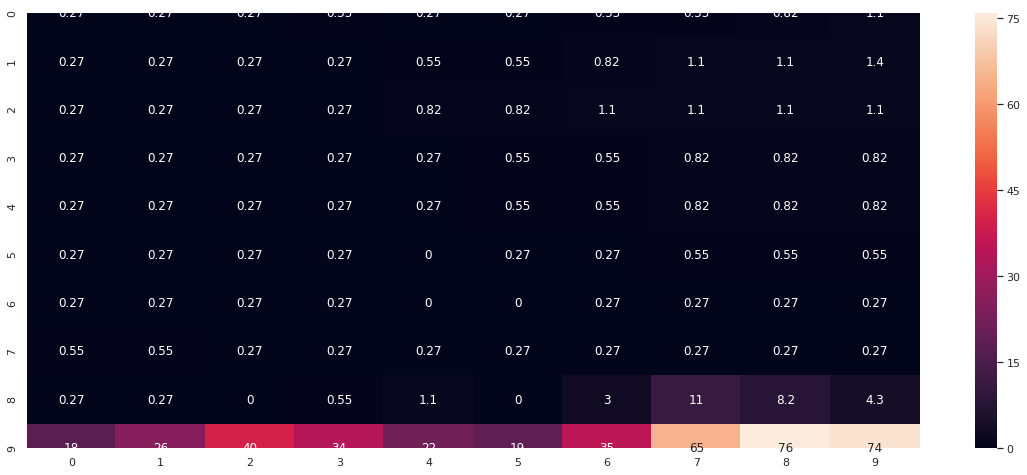

In [40]:
print(rgb2lab_frames.shape)
print(np.amax(rgb2lab_frames[0,:,:,0]))
sns.heatmap(rgb2lab_frames[0,80:90,80:90,0],annot=True )

(459, 240, 320, 3)
100.0


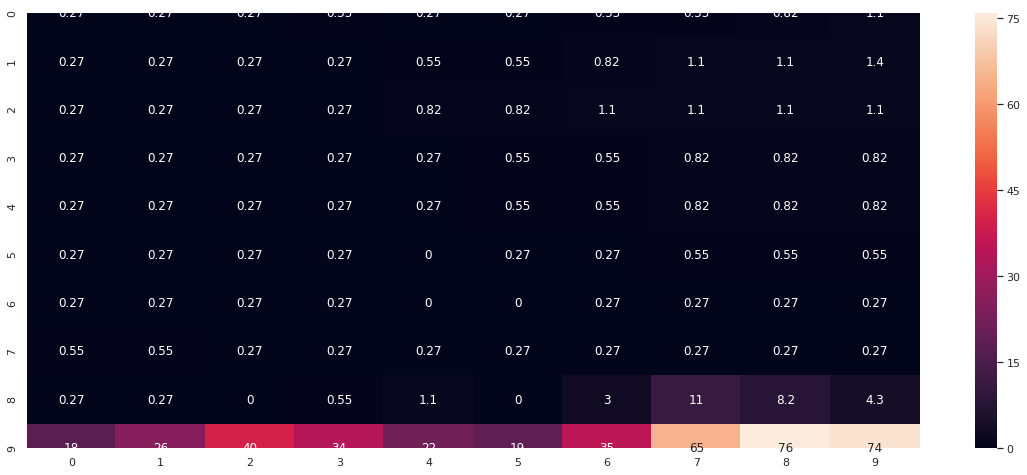

In [41]:
print(gray2lab_frames.shape)
print(np.amax(gray2lab_frames[0,:,:,0]))
sns.heatmap(gray2lab_frames[0,80:90,80:90,0],annot=True )

(459, 240, 320, 1)
1.0


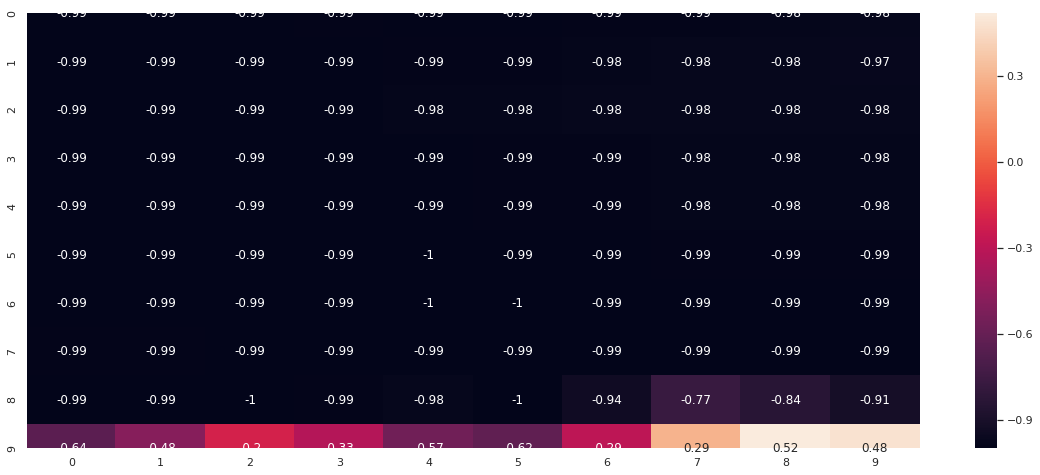

In [42]:
print(processed_l_layer.shape)
print(np.amax(processed_l_layer[0,:,:,0]))
sns.heatmap(processed_l_layer[0,80:90,80:90,0],annot=True )

In [36]:
# get resnet embeddings
predictions = get_resnet_records(frames)
print("Completed calculating resnet records ")

Completed calculating resnet records 


In [0]:
!cp /content/drive/My\ Drive/checkpoints/flowchroma-epoch-00003-lr-0.0001-train_loss-0.0057.hdf5 /content/drive/My\ Drive/model.hdf5

In [47]:
# run flowchroma model
ckpts = glob.glob("/content/drive/My Drive/*.hdf5")
latest_ckpt = max(ckpts, key=os.path.getctime)
# latest_ckpt = ckpts[0]
print("loading from checkpoint:", latest_ckpt)
model = load_model(latest_ckpt, custom_objects={'FusionLayer': FusionLayer})
X = get_nn_input(processed_l_layer, predictions)
predictions = model.predict(X)

print("Flowchroma model predictions calculated")

loading from checkpoint: /content/drive/My Drive/model.hdf5
Flowchroma model predictions calculated


In [48]:
frame_predictions = post_process_predictions(gray2lab_frames[:,:,:,0], predictions)
print(frame_predictions.shape)
print(rgb2lab_frames.shape)

(459, 240, 320, 3)
(459, 240, 320, 3)


## L layer

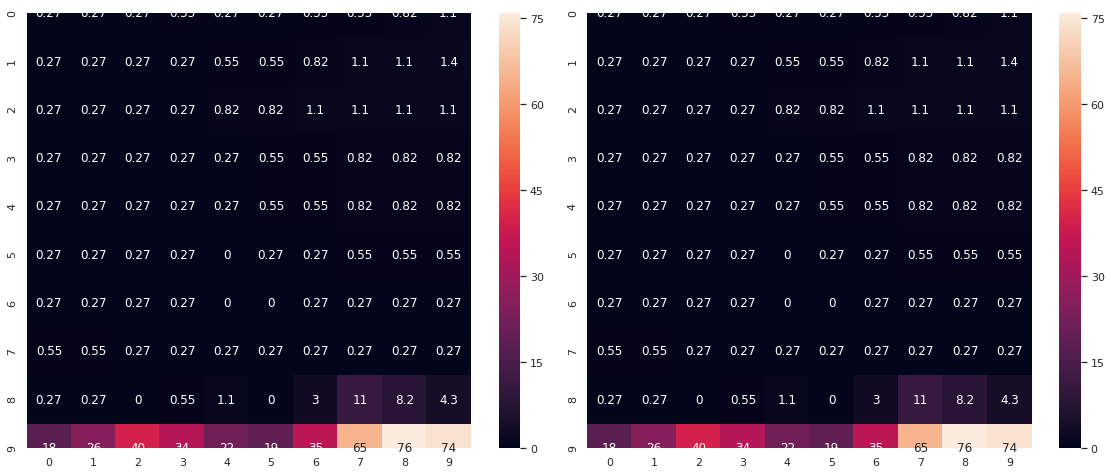

In [49]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(frame_predictions[0,80:90,80:90,0],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,0],annot=True, ax=ax2 )

## a layer

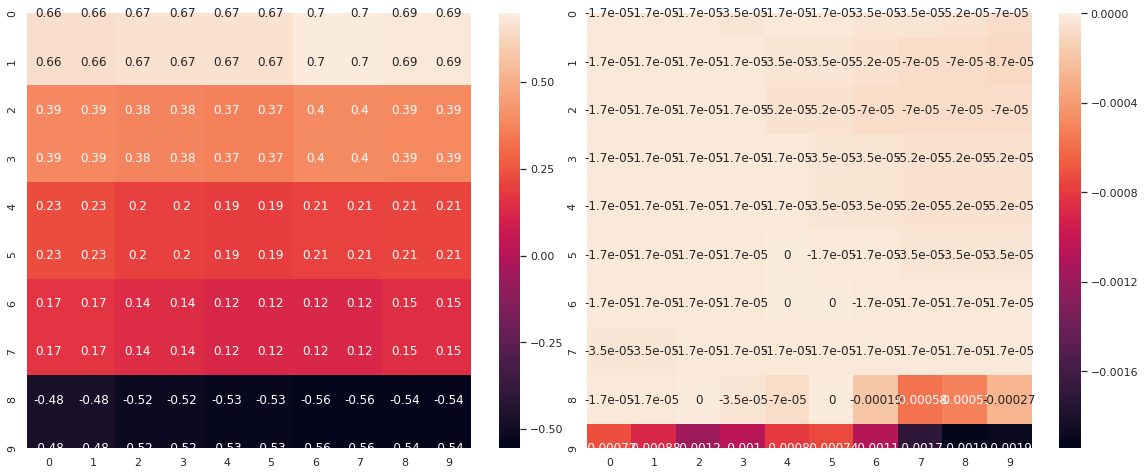

In [50]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,80:90,80:90,1],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,1],annot=True, ax=ax2 )

## b layer

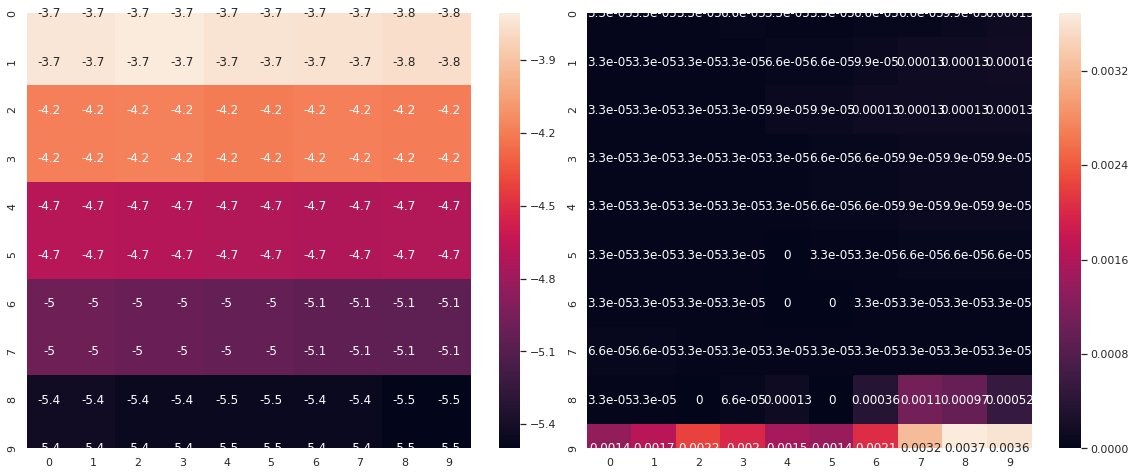

In [51]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,80:90,80:90,2],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,2],annot=True, ax=ax2 )